In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal,stats
from scipy.stats import theilslopes

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

import pymannkendall

import warnings
warnings.filterwarnings('ignore')

data_base_name = "p"
db_data_filename = "p20_260125"

In [2]:
   
data_filename = f"data\{db_data_filename}.csv"
print(f'read {data_filename}')

columns = ['_time','pressure_1','pressure_2','temperature_1','temperature_2','velocity_1','velocity_2']

frame = pd.read_csv(data_filename, skiprows=[0,1,2], usecols=columns)
frame['_time'] = pd.to_datetime(frame['_time'], format="ISO8601")

series_name = "pressure_1"
   
times = frame["_time"]
series = frame[series_name]


read data\p20_260125.csv


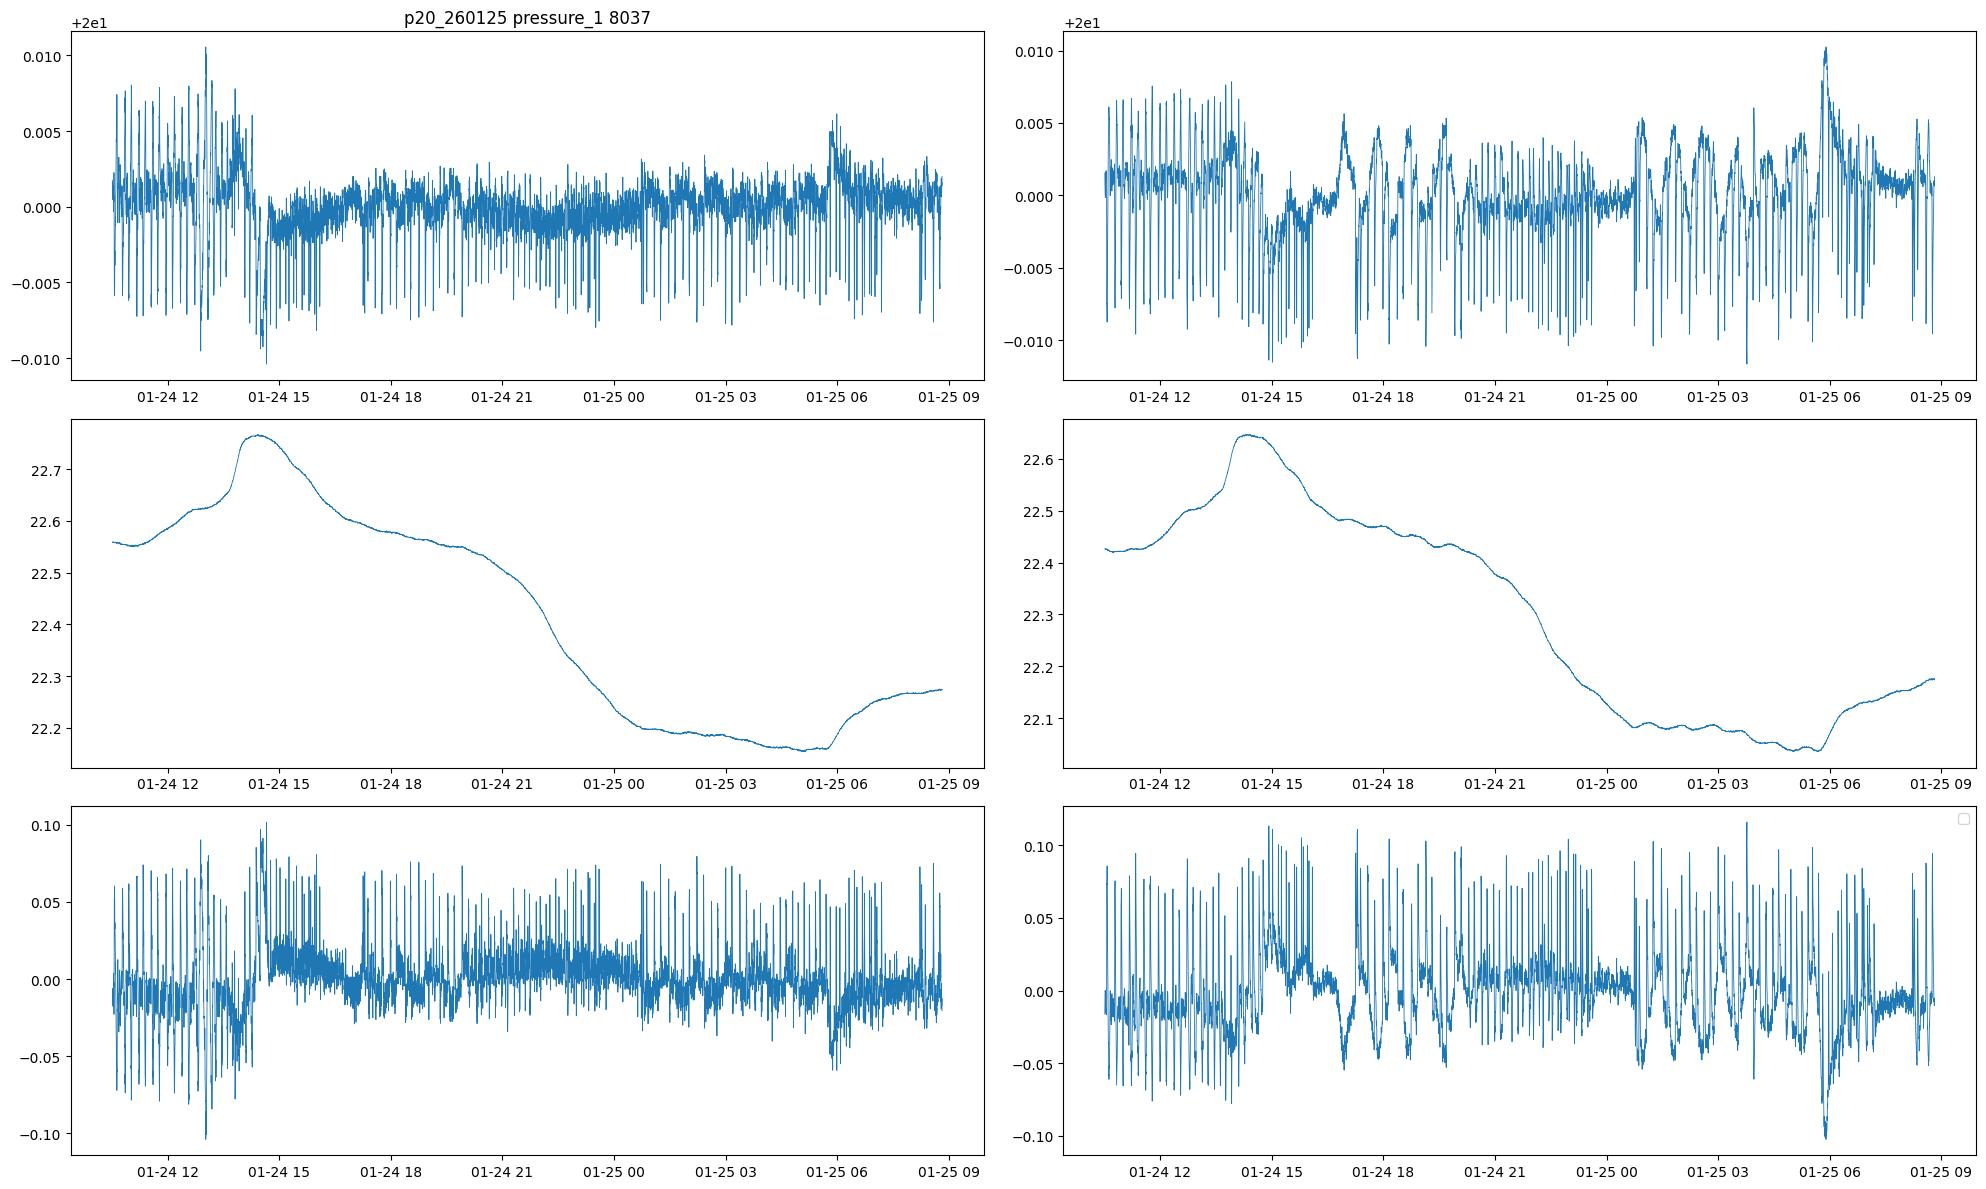

In [11]:
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))

for j,keyj in enumerate(["pressure","temperature","velocity"]):
    for i,keyi in enumerate(["1","2"]):
        ax[j,i].plot(frame["_time"], frame[f"{keyj}_{keyi}"], '-', lw=0.6)
        if j+i == 0:
            ax[j,i].set_title(f"{db_data_filename} {series_name} {len(series)}")


plt.legend()
plt.tight_layout()
plt.show()


In [12]:

def statistical_trend_tests(series):    

    rcc = {}    

    # Mann-Kendall trend test (non-parametric)
    try:

        rc = pymannkendall.original_test(series)
        rcc['mann_kendall'] = { 'trend': rc.trend, 'p_value': rc.p, 'slope': rc.slope, 'intercept': rc.intercept }

        rc = pymannkendall.hamed_rao_modification_test(series)
        rcc['hamed_rao'] = { 'trend': rc.trend, 'p_value': rc.p, 'slope': rc.slope, 'intercept': rc.intercept }
        
        #rc = pymannkendall.yue_wang_modification_test(series)
        #rcc['yue_wang'] = { 'trend': rc.trend, 'p_value': rc.p, 'slope': rc.slope, 'intercept': rc.intercept }

        #rc = pymannkendall.pre_whitening_modification_test(series)
        #rcc['pre_whitening'] = { 'trend': rc.trend, 'p_value': rc.p, 'slope': rc.slope, 'intercept': rc.intercept }

    except Exception as x:
        print(x)
    
    # Spearman's rank correlation
    rc = stats.spearmanr(np.arange(len(series)), series)
    rcc['spearman'] = { 'correlation': rc.correlation, 'p_value': rc.pvalue }    
    
    # linear regression
    x = np.arange(len(series))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, series)
    rcc['linear_regression'] = { 'r_squared': r_value**2, 'p_value': p_value, 'slope': slope, 'intercept': intercept }    
    
    # trend-strength
    # Theil-Sen estimator (robust to anomalies)    
    rc = theilslopes(series, np.arange(len(series)))
    rcc['theil_sen'] = { 'slope': rc.slope, 'intercept': rc.intercept }    
    return pd.DataFrame(rcc)

trend_tests = statistical_trend_tests(series.copy())
print(f"statistical '{series_name}'")
print(trend_tests)

statistical 'pressure_1'
            mann_kendall  hamed_rao  spearman  linear_regression     theil_sen
trend         increasing   no trend       NaN                NaN           NaN
p_value              0.0   0.562397  0.000263       1.011131e-01           NaN
slope                0.0        0.0       NaN       1.744672e-08  4.398585e-08
intercept      19.999915  19.999915       NaN       1.999984e+01  1.999992e+01
correlation          NaN        NaN  0.040696                NaN           NaN
r_squared            NaN        NaN       NaN       3.344885e-04           NaN


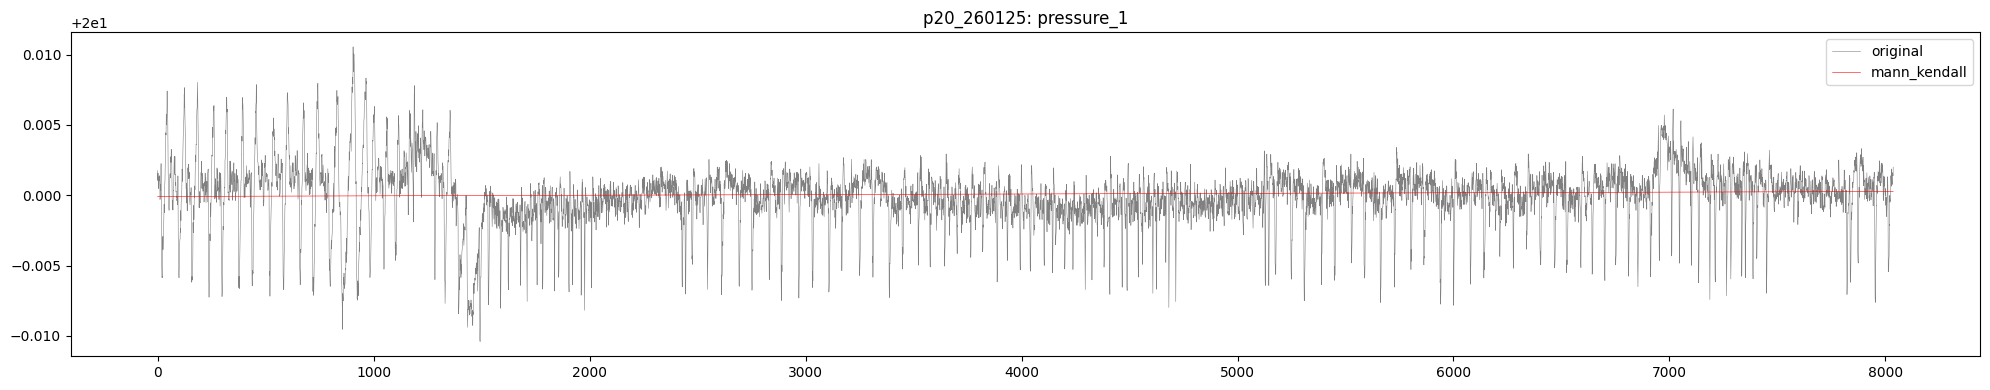

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

lw = 0.4

x = range(len(series))
ax.plot(x,series, "-", lw=lw, c='gray', label='original')

for key in ['mann_kendall']:
    ax.plot(x,trend_tests[key]['slope']*x + trend_tests['mann_kendall']['intercept'], "-", lw=lw, c='red', label=key)

plt.title(f"{db_data_filename}: {series_name}")

plt.legend()
plt.tight_layout()
plt.show()

In [14]:

def calculate_trend_metrics(series, win=50):

    metrics = {}
    
    # linear component
    x = np.arange(len(series))
    slope, intercept = np.polyfit(x, series, 1)
    metrics['linear_slope'] = slope
    metrics['linear_intercept'] = intercept
    
    # average change
    avg_change = series.diff().dropna()
    metrics['avg_change'] = avg_change.mean()
    metrics['std_change'] = avg_change.std()
    
    # strength (variance by trend)
    trend_line = intercept + slope * x
    residuals = series - trend_line
    total_variance = np.var(series)
    trend_variance = np.var(trend_line)
    metrics['trend_strength'] = trend_variance / total_variance if total_variance > 0 else 0
    
    # rolling window
    rolling_trends = series.rolling(window=win).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0])
    metrics['rolling_trend_mean'] = rolling_trends.mean()
    metrics['rolling_trend_std'] = rolling_trends.std()
    metrics['rolling_trend_window'] = win 
    
    # 5. Trend-Klassifikation
    if abs(slope) < 0.01:
        metrics['trend_class'] = 'neutral'
    elif slope > 0.01:
        metrics['trend_class'] = 'increasing'
    else:
        metrics['trend_class'] = 'decreasing'
    
    return pd.Series(metrics)

win = np.sqrt(len(series)).astype(np.int32)

trend_metrics = calculate_trend_metrics(series, win)
print(f"trend metrics '{series_name}'")
print(trend_metrics)

trend metrics 'pressure_1'
linear_slope                  0.0
linear_intercept        19.999837
avg_change                    0.0
std_change               0.001047
trend_strength           0.000334
rolling_trend_mean           -0.0
rolling_trend_std        0.000019
rolling_trend_window           89
trend_class               neutral
dtype: object


In [15]:
def advanced_trend_decomposition(series, period=30):
    
    from statsmodels.tsa.seasonal import STL
    
    # STL decomposition
    stl = STL(endog=series, period=period, robust=True)
    result = stl.fit()
        
    # trend strength
    trend_strength = 1 - (np.var(result.resid) / np.var(result.trend + result.resid))
    seasonal_strength = 1 - (np.var(result.resid) / np.var(result.seasonal + result.resid))
    
    decomposition_metrics = {
        'trend_strength': max(0, min(1, trend_strength)),
        'seasonal_strength': max(0, min(1, seasonal_strength)),
        'noise_ratio': np.var(result.resid) / np.var(series),
        'trend_slope': np.polyfit(np.arange(len(result.trend.dropna())), 
                                  result.trend.dropna(), 1)[0]
    }
    
    return result, pd.Series(decomposition_metrics)

period = int(np.sqrt(len(series)))

stl_result, stl_metrics = advanced_trend_decomposition(series, period=period)
print(f"STL decomposition metrics '{series_name}'")
print(stl_metrics)


#nrows = 1
#fig, ax = plt.subplots(nrows,1,figsize=(20, nrows * 5))

#stl_result.plot(ax=ax)

#fig = result.plot()
#plt.suptitle(f'STL Decomposition (Period={period})', fontsize=16)
#plt.tight_layout()
#plt.show()

STL decomposition metrics 'pressure_1'
trend_strength       1.948391e-01
seasonal_strength    8.819456e-02
noise_ratio          7.474067e-01
trend_slope          2.862040e-08
dtype: float64


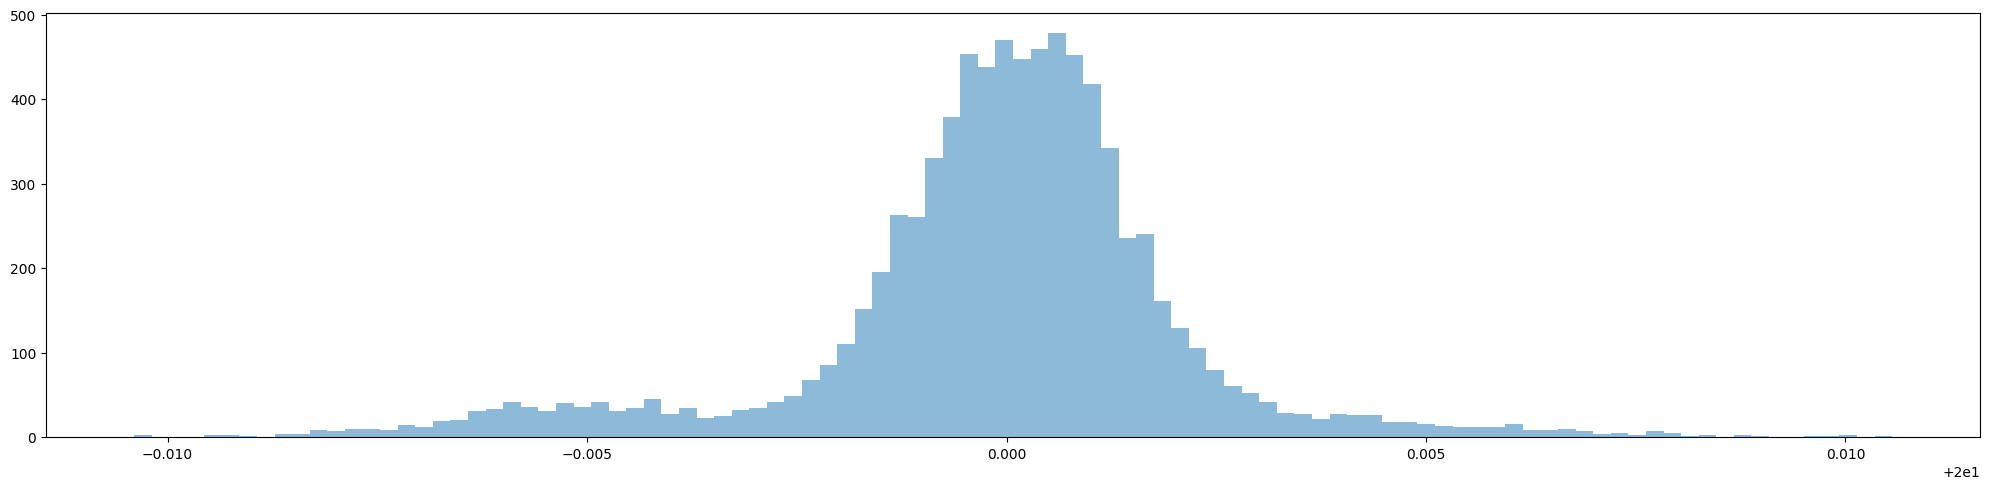

In [16]:
nrows = 1
fig, ax = plt.subplots(nrows,1,figsize=(20, nrows * 5))

ax.hist(series, bins=100, alpha=0.5)

plt.tight_layout()
plt.show()

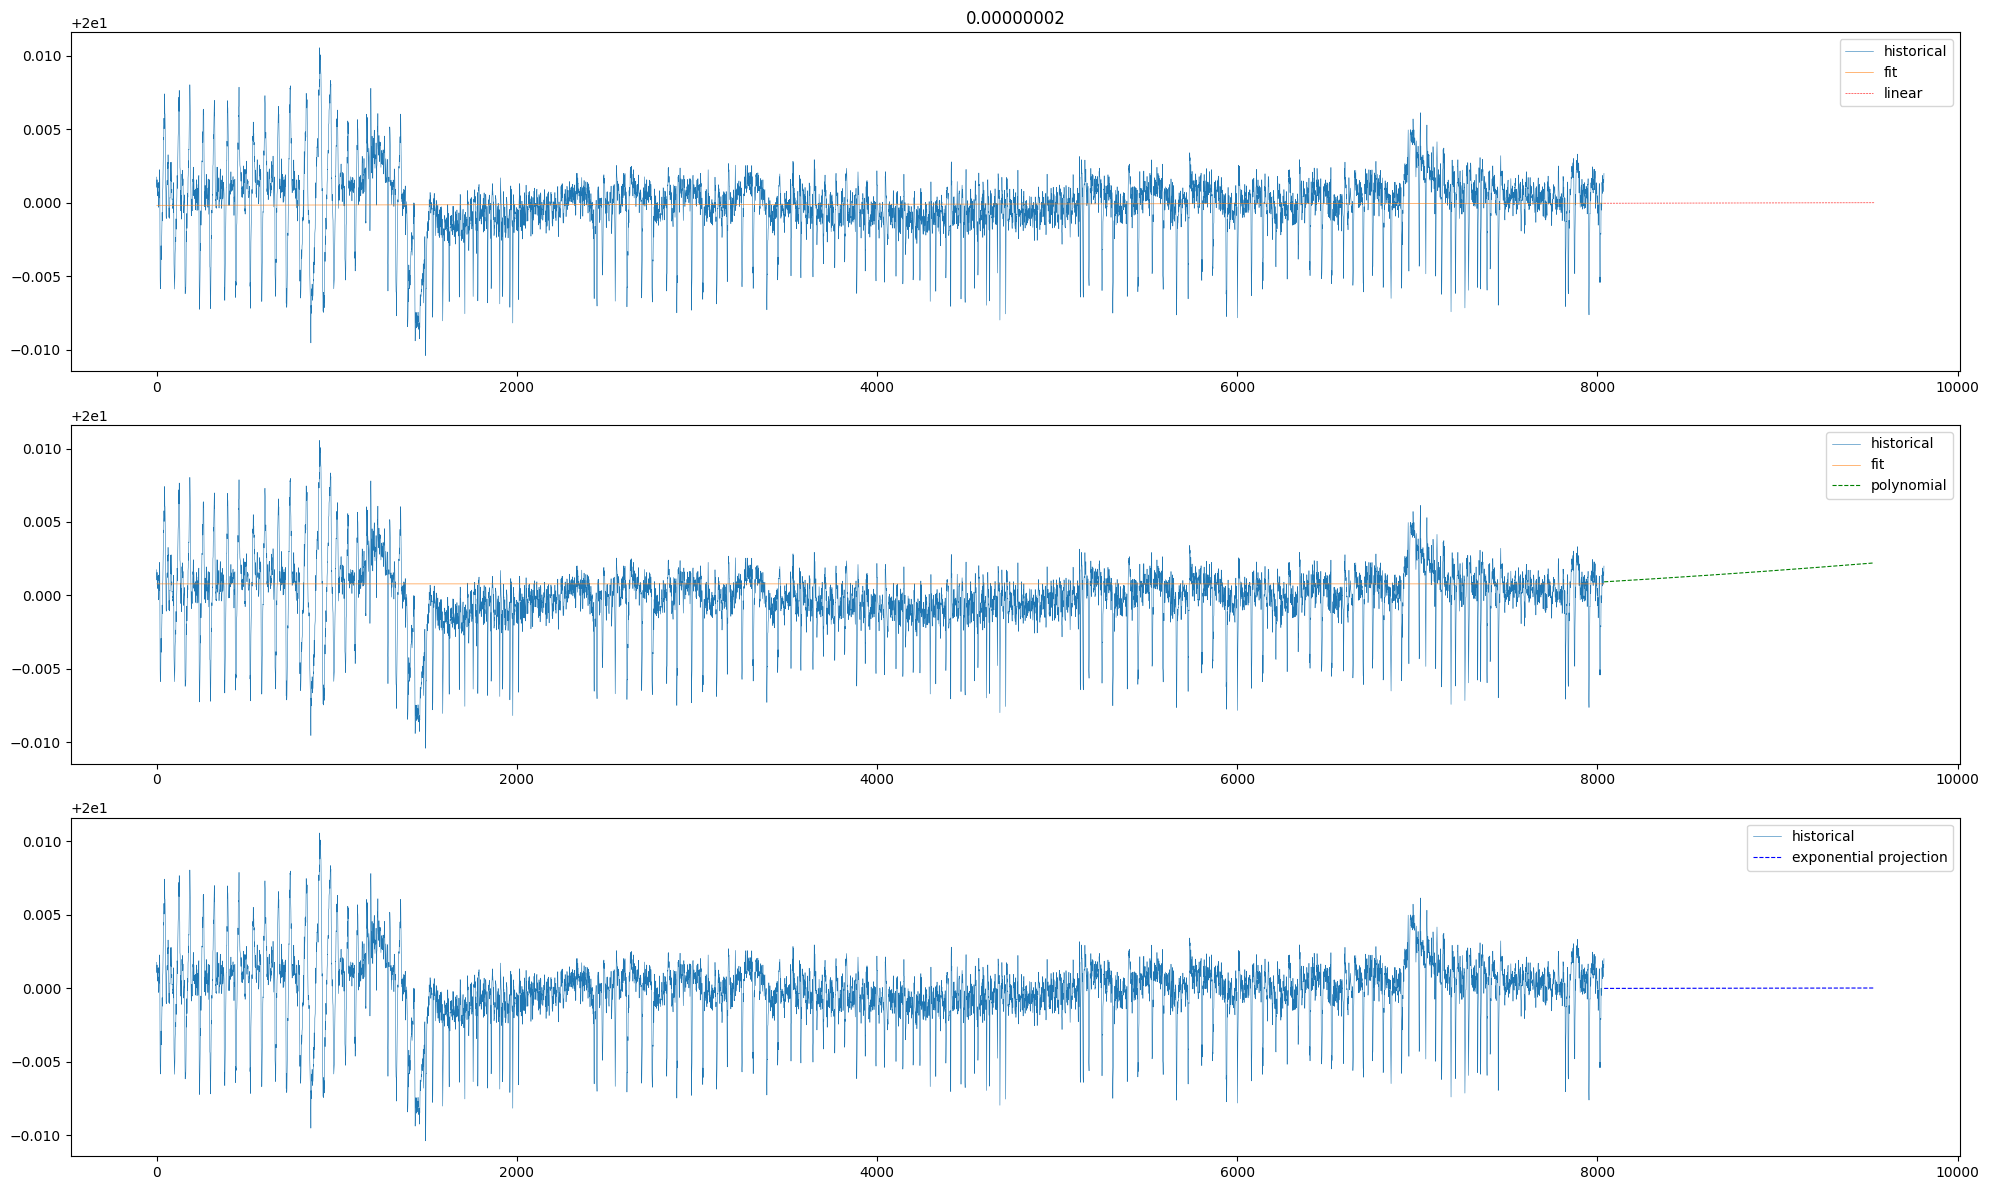

In [17]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def forecast_trend(series, periods=30, method='linear'):
    
    lw = 0.4
    
    # data
    y = series
    X = np.arange(len(y)).reshape(-1, 1)
    
    # future periods
    X_future = np.arange(len(y), len(y) + periods).reshape(-1, 1)
    
    fig, ax = plt.subplots(3,1, figsize=(20, 12))
    
    # linear projection
    if method in ['linear', 'all']:

        model_lin = LinearRegression()
        model_lin.fit(X, y)
        y_pred_lin = model_lin.predict(X_future)
        
        ax[0].plot(X, y, label='historical', lw=lw)
        ax[0].plot(X, model_lin.coef_ * X + model_lin.intercept_, label='fit', lw=lw)
        ax[0].plot(X_future, y_pred_lin, 'r--', label='linear', lw=lw)
        ax[0].set_title(f'{model_lin.coef_[0]:.8f}')
        ax[0].legend()
    
    # polynomial projection (degree 2)
    if method in ['poly', 'all']:

        poly = PolynomialFeatures(degree=2)

        X_poly = poly.fit_transform(X)
        X_future_poly = poly.transform(X_future)
        
        model_poly = LinearRegression()
        model_poly.fit(X_poly, y)
        y_pred_poly = model_poly.predict(X_future_poly)
        
        ax[1].plot(X, y, label='historical', lw=lw)
        ax[1].plot(X, model_poly.coef_[0] * X + model_poly.intercept_, label='fit', lw=lw)
        ax[1].plot(X_future, y_pred_poly, 'g--', label='polynomial', lw=lw*2)
        ax[1].legend()
    
    # exponential projection
    if method in ['exp', 'all']:
        # Log-transform for exponential growth
        y_log = np.log(y - y.min() + 1)
        model_exp = LinearRegression()
        model_exp.fit(X, y_log)
        y_pred_exp = np.exp(model_exp.predict(X_future)) + y.min() - 1
        
        ax[2].plot(X, y, label='historical', lw=lw)
        ax[2].plot(X_future, y_pred_exp, 'b--', label='exponential projection', lw=lw * 2)
        ax[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'linear': y_pred_lin if 'linear' in method else None,
        'polynimial': y_pred_poly if 'poly' in method else None,
        'exponential': y_pred_exp if 'exp' in method else None
    }

# projections
forecasts = forecast_trend(series, periods=1500, method='all')


In [ ]:
class TrendAnalyzer:
    """
    Komplette Trendanalyse-Pipeline
    """
    def __init__(self, series):
        self.series = series
        self.results = {}
        
    def analyze(self):
        """Führt komplette Trendanalyse durch"""
        
        # 1. Deskriptive Statistik
        self.results['descriptive'] = series.describe()
        
        # 2. Trendtests
        self.results['statistical_tests'] = statistical_trend_tests(self.series)
        
        # 3. Trend-Metriken
        self.results['trend_metrics'] = calculate_trend_metrics(self.series)
        
        # 4. STL Decomposition
        stl_result, stl_metrics = advanced_trend_decomposition(
            self.series, period=30
        )
        self.results['stl'] = stl_result
        self.results['stl_metrics'] = stl_metrics
        
        # 5. Zusammenfassung
        self.results['summary'] = self._generate_summary()
        
        return self.results
    
    def _generate_summary(self):
        """Erstellt Trend-Zusammenfassung"""
        summary = {
            'has_trend': self.results['statistical_tests'].loc['p_value', 'linear_regression'] < 0.05,
            'trend_direction': self.results['trend_metrics']['trend_class'],
            'trend_strength': self.results['trend_metrics']['trend_strength'],
            'seasonal_strength': self.results['stl_metrics']['seasonal_strength'],
            'recommended_analysis': self._get_recommendations()
        }
        return summary
    
    def _get_recommendations(self):
        """Gibt Empfehlungen basierend auf den Ergebnissen"""
        recommendations = []
        
        if self.results['trend_metrics']['trend_strength'] > 0.7:
            recommendations.append("Starker Trend vorhanden - Trend-basierte Modelle geeignet")
        
        if self.results['stl_metrics']['seasonal_strength'] > 0.3:
            recommendations.append("Starke Saisonalität - Saisonbereinigung empfohlen")
        
        if self.results['trend_metrics']['std_daily_change'] > self.results['trend_metrics']['avg_daily_change']:
            recommendations.append("Hohe Volatilität - Robuste Methoden verwenden")
        
        return recommendations
    
    def report(self):
        """Erstellt einen detaillierten Report"""
        print("=" * 60)
        print("TRENDANALYSE REPORT")
        print("=" * 60)
        print(f"\n1. DATENÜBERSICHT:")
        print(f"   Datenpunkte: {len(self.series)}")
        
        print(f"\n2. TREND ERKENNUNG:")
        trend_class = self.results['trend_metrics']['trend_class']
        p_value = self.results['statistical_tests'].loc['p_value', 'linear_regression']
        print(f"   Trendrichtung: {trend_class}")
        print(f"   Statistische Signifikanz: {'Signifikant' if p_value < 0.05 else 'Nicht signifikant'}")
        print(f"   Trendstärke: {self.results['trend_metrics']['trend_strength']:.1%}")
        
        print(f"\n3. EMPFEHLUNGEN:")
        for rec in self.results['summary']['recommended_analysis']:
            print(f"   • {rec}")
        print("=" * 60)

# Komplette Analyse durchführen
analyzer = TrendAnalyzer(series)
results = analyzer.analyze()
analyzer.report()